In [31]:
import numpy as np
import datetime
import time

In [32]:
BOARD_ROWS = 3
BOARD_COLS = 4
START = (0, 0)
END = (1, 0)

In [33]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.state = state    # tuple of the coordinate
        self.is_end = False

    def next_position(self, action):
        if action == "up":
            next_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            next_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)
        if (next_state[0] >= 0) and (next_state[0] < BOARD_ROWS):
            if (next_state[1] >= 0) and (next_state[1] < BOARD_COLS):
                return next_state
        return self.state


In [34]:
class Agent:

    def __init__(self):
        self.State = State()
        self.actions = ["up", "down", "left", "right"]
        self.alpha = 0.3
        self.exp_rate = 1
        self.decay_gamma = 0.9
        self.Q_values = {}  # init Q values (dict)
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        self.past_all = []
        for i in range(BOARD_ROWS):
            t = []
            for j in range(BOARD_COLS):
                t.append(False)
            self.past_all.append(t)

        self.steps = []
        self.done = False
        self.step = 0
        self.states=[]
        self.all_states=[]
        self.result = ""
        self.total_reward = 0
        self.rewards = []
    
    # get the possible action space
    def get_actions(self,state):
        i, j = state[0], state[1]
        potential_position = []
        if i + 1 < BOARD_ROWS:
            potential_position.append("down")
        if i - 1 >= 0:
            potential_position.append("up")
        if j + 1 < BOARD_COLS:
            potential_position.append("right")
        if j - 1 >= 0:
            potential_position.append("left")
        return potential_position
    
    def optimal_action(self):
        max_value = -10000
        action = ""
        actions = self.get_actions(self.State.state)
        for a in actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action
    
    def get_action(self):
        """
        The agent should choose randomly among the positions that have
        not been visited, and if all possible positions are visited, 
        then move randomly and the game is failing
        """
        actions = self.get_actions(state = self.State.state)
        if np.random.uniform(0, 1) <= self.exp_rate:
            t = []
            for a in actions:
                p = self.State.next_position(a)
                if self.past_all[p[0]][p[1]] is True:
                    t.append(1)
                else:
                    t.append(0)
            if sum(t) == len(t):
                return np.random.choice(actions)
            else:
                while True:
                    action = np.random.choice(actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] is False:
                        return action
                    continue
        else:
            return self.optimal_action()

    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True
    
    def check_win(self):
        if self.State.state == END and self.check_all_past():
            self.result = "win"
        # find if all grids around the unvisit grid are visited
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.past_all[i][j] is False:
                    t = []
                    actions = self.get_actions(state = (i, j))
                    for a in actions:
                        p = State(state=(i,j)).next_position(a)
                        if self.past_all[p[0]][p[1]] is True:
                            t.append(1)
                        else:
                            t.append(0)
                    if sum(t) == len(t):
                        self.result = "loss"
            continue
        
        if self.result == "win" or self.result == "loss":
            self.done = True
         
    def give_reward(self):
        reward = 1
        if self.result == "win":
            reward += 1
        if self.result == "loss":
            reward -= 1000
        return reward
    
    def set_action(self, action):
        self.step += 1
        curr_state = self.State.state
        self.states.append(curr_state)
        self.past_all[curr_state[0]][curr_state[1]] = True
        next_state = self.State.next_position(self.get_action())
        self.State = State(state=next_state)
        
        reward = self.give_reward()
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
        else:
            self.done = True
            reward -= 1   # penalty for repeat
        
        self.total_reward += reward
        
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha * (reward + self.decay_gamma * (max(qs_of_next_state)) -
                              self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action] + delta, 4)
    
    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.done = False
        self.step = 0
        self.states=[]
        self.result = ""
        self.total_reward = 0
        
    def train(self, rounds=1000):
        print("Training...")
        for r in range(rounds):
            self.reset()
            self.exp_rate *= 0.99
            while not self.done:
                self.check_win()
                action = self.get_action()
                self.set_action(action)
            self.rewards.append(self.total_reward)
            self.steps.append(self.step)
            self.all_states.append(self.states)
#             print(self.Q_values)
#             print(self.step)
        print("Training finished!")
    
    def show_path(self):
        for i in range(BOARD_ROWS):
            print('---------------------------------------')
            row_string = "| "
            for j in range(BOARD_COLS):
                best_move = ""
                best_val = -1000000
                for a in self.Q_values[(i,j)]:
                    if self.Q_values[(i, j)][a] > best_val:
                        best_val = self.Q_values[(i,j)][a]
                        best_move = a
                row_string = row_string + " " + best_move + " |"
            print(row_string)
        print('---------------------------------------')   

In [35]:
agent = Agent()
start_time = datetime.datetime.now()
agent.train()
end_time = datetime.datetime.now()
time_period = (end_time - start_time).total_seconds()
print(agent.Q_values)

Training...
Training finished!
{(0, 0): {'up': 0, 'down': 4.5026, 'left': 0, 'right': 5.2164}, (0, 1): {'up': 0, 'down': 3.7116, 'left': 0, 'right': 4.685}, (0, 2): {'up': 0, 'down': 4.0946, 'left': -547.5247, 'right': 3.5245}, (0, 3): {'up': 0, 'down': 0.9998, 'left': -69.5359, 'right': 0}, (1, 0): {'up': -995.3054, 'down': -995.5374, 'left': 0, 'right': -996.0455}, (1, 1): {'up': -296.2771, 'down': -296.57, 'left': 0.9999, 'right': -38.8905}, (1, 2): {'up': 2.453, 'down': 3.4386, 'left': 2.7407, 'right': 2.5536}, (1, 3): {'up': -743.9196, 'down': -790.9245, 'left': -650.246, 'right': 0}, (2, 0): {'up': -855.4848, 'down': 0, 'left': 0, 'right': -23.7432}, (2, 1): {'up': 1.8998, 'down': 0, 'left': -15.4198, 'right': -10.1652}, (2, 2): {'up': -206.8312, 'down': 0, 'left': 2.7097, 'right': -100.494}, (2, 3): {'up': 0.7477, 'down': 0, 'left': 1.5666, 'right': 0}}


In [36]:
print("Running time: ", time_period)

Running time:  0.541698


In [37]:
agent.show_path()

---------------------------------------
|  right | right | down | down |
---------------------------------------
|  left | left | down | right |
---------------------------------------
|  down | up | left | left |
---------------------------------------


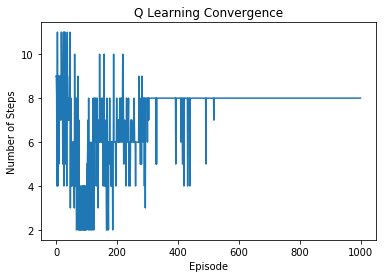

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
x = []
for i in range(1000):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

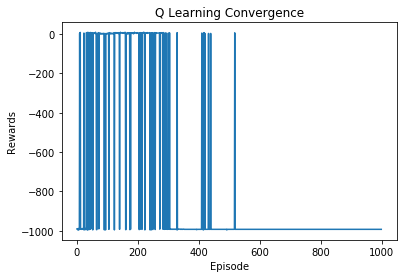

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
x = []
for i in range(1000):
    x.append(i)
y = agent.rewards
plt.plot(x,y)
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

In [40]:
# agent.all_states